In [1]:
# importing libraires

import gc
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import shap

from mlxtend.regressor import StackingRegressor
from mlxtend.data import boston_housing_data
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR

import warnings
warnings.filterwarnings('ignore')

BASE = '../input/godaddy-microbusiness-density-forecasting/'

# Setting plot styles
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
# Loading data
train = pd.read_csv(BASE + 'train.csv')
test = pd.read_csv(BASE + 'test.csv')
sub = pd.read_csv(BASE + 'sample_submission.csv')
train.shape, test.shape, sub.shape

((122265, 7), (25080, 3), (25080, 2))

In [3]:
# Loading the rest of county info
county_info =  pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/census_starter.csv")
county_info.head()

,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [4]:
# Loading the 10-year tresury yield data
ten_y = pd.read_csv("/kaggle/input/godaddy-metadata/clean_data/10yr_treasury_rate.csv")
ten_y['first_day_of_month'] = pd.to_datetime(ten_y['first_day_of_month'])
ten_y

,first_day_of_month,DGS10_last
0,2018-02-01,2.72
1,2018-03-01,2.87
2,2018-04-01,2.74
3,2018-05-01,2.95
4,2018-06-01,2.83
...,...,...
56,2022-10-01,3.83
57,2022-11-01,4.10
58,2022-12-01,3.68
59,2023-01-01,3.88


In [5]:
# converting to datetime
train["first_day_of_month"] = pd.to_datetime(train["first_day_of_month"])

# converting to datetime
test["first_day_of_month"] = pd.to_datetime(test["first_day_of_month"])

In [6]:
# merging ten_y with train and test
test = pd.merge(test, ten_y, how="left", on="first_day_of_month")
train = pd.merge(train, ten_y, how="left", on="first_day_of_month")

In [7]:
train.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,DGS10_last
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2.02
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,1.50
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,1.68
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,1.69
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,1.78


In [8]:
# Creating new timeseries features
def create_features(df,col):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df[col].dt.quarter
    df['month'] = df[col].dt.month
    df['year'] = df[col].dt.year
    df['dayofyear'] = df[col].dt.dayofyear
    df['weekofyear'] = df[col].dt.isocalendar().week
    return df

train = create_features(train,"first_day_of_month")

In [9]:
test = create_features(test,"first_day_of_month")

In [10]:
train["weekofyear"] = train["weekofyear"].astype(int)
test["weekofyear"] = test["weekofyear"].astype(int)

In [11]:
train.columns

Index(['row_id', 'cfips', 'county', 'state', 'first_day_of_month',
       'microbusiness_density', 'active', 'DGS10_last', 'quarter', 'month',
       'year', 'dayofyear', 'weekofyear'],
      dtype='object')

In [12]:
# Creating lag features
train["lag_1"] = train["microbusiness_density"].shift(1)
train["lag_2"] = train["microbusiness_density"].shift(2)
train["lag_3"] = train["microbusiness_density"].shift(3)
train["lag_4"] = train["microbusiness_density"].shift(4)

## Checking partial autocorrelation of lag features

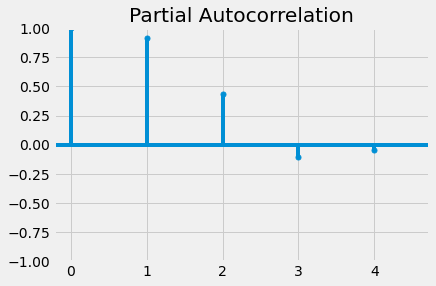

In [13]:
from statsmodels.graphics.tsaplots import plot_pacf
_ = plot_pacf(train.microbusiness_density, lags=4)

Hence, we will only use the first two

In [14]:
# Dropping lag_3 and lag_4
train.drop(["lag_3","lag_4"], inplace=True, axis=1)

In [15]:
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,DGS10_last,quarter,month,year,dayofyear,weekofyear,lag_1,lag_2
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2.02,3,8,2019,213,31,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,1.50,3,9,2019,244,35,3.007682,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,1.68,4,10,2019,274,40,2.884870,3.007682
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,1.69,4,11,2019,305,44,3.055843,2.884870
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,1.78,4,12,2019,335,48,2.993233,3.055843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101,2.85,2,6,2022,152,22,1.803249,1.767542
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101,2.98,3,7,2022,182,26,1.803249,1.803249
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100,2.67,3,8,2022,213,31,1.803249,1.803249
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100,3.15,3,9,2022,244,35,1.785395,1.803249


In [16]:
test

,row_id,cfips,first_day_of_month,DGS10_last,quarter,month,year,dayofyear,weekofyear
0,1001_2022-11-01,1001,2022-11-01,4.1,4,11,2022,305,44
1,1003_2022-11-01,1003,2022-11-01,4.1,4,11,2022,305,44
2,1005_2022-11-01,1005,2022-11-01,4.1,4,11,2022,305,44
3,1007_2022-11-01,1007,2022-11-01,4.1,4,11,2022,305,44
4,1009_2022-11-01,1009,2022-11-01,4.1,4,11,2022,305,44
...,...,...,...,...,...,...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01,NaN,2,6,2023,152,22
25076,56039_2023-06-01,56039,2023-06-01,NaN,2,6,2023,152,22
25077,56041_2023-06-01,56041,2023-06-01,NaN,2,6,2023,152,22
25078,56043_2023-06-01,56043,2023-06-01,NaN,2,6,2023,152,22


In [17]:
ids = train.cfips.unique()

In [18]:
train['is_test'] = 0
test['is_test'] = 1

In [19]:
# Concat both datasets under one dataframe.
data = pd.concat((train, test)).sort_values('row_id').reset_index(drop = True)

In [20]:
# Filling test lags with the last two known values
data['lag_1'] = data.groupby('cfips')['lag_1'].ffill()
data['lag_2'] = data.groupby('cfips')['lag_2'].ffill()

In [21]:
# Defining target metric (SMAPE)
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [22]:
ids.shape

(3135,)

In [23]:
train.dtypes

row_id                           object
cfips                             int64
county                           object
state                            object
first_day_of_month       datetime64[ns]
microbusiness_density           float64
active                            int64
DGS10_last                      float64
quarter                           int64
month                             int64
year                              int64
dayofyear                         int64
weekofyear                        int64
lag_1                           float64
lag_2                           float64
is_test                           int64
dtype: object

In [24]:
features=['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
        'pct_bb_2021', 'pct_college_2017', 'pct_college_2018',
        'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
        'pct_foreign_born_2017', 'pct_foreign_born_2018',
        'pct_foreign_born_2019', 'pct_foreign_born_2020',
        'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
        'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
        'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
        'median_hh_inc_2020', 'median_hh_inc_2021', 'quarter', 'month', 'year',
        'dayofyear', 'weekofyear']

## XGBoost

In [25]:
"""
features=['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
        'pct_bb_2021', 'pct_college_2017', 'pct_college_2018',
        'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
        'pct_foreign_born_2017', 'pct_foreign_born_2018',
        'pct_foreign_born_2019', 'pct_foreign_born_2020',
        'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
        'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
        'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
        'median_hh_inc_2020', 'median_hh_inc_2021', 'quarter', 'month', 'year',
        'dayofyear', 'weekofyear']

# Initialise where we will store forecasts
test["TARGET"] = 0


for id in ids:
    
    # Get time series for the county
    train_cfip = train[train["cfips"]==id]
    model = xgb.XGBRegressor(tree_method="gpu_hist",eval_metric="mae",enable_categorical=True)
    model.fit(train_cfip[features],train_cfip["microbusiness_density"])
    
    # Get the test set
    test_cfip = test[test["cfips"]==id]
                         
    forecasts_list = []
    for leadtime in range(8):
        forecast = model.predict(test_cfip[features])
        test["TARGET"].loc[test['cfips'] == id] = forecast
        
    # Save forecasts
    #test["TARGET"].loc[test['cfips'] == id] = forecasts_list
"""

'\nfeatures=[\'pct_bb_2017\', \'pct_bb_2018\', \'pct_bb_2019\', \'pct_bb_2020\',\n        \'pct_bb_2021\', \'pct_college_2017\', \'pct_college_2018\',\n        \'pct_college_2019\', \'pct_college_2020\', \'pct_college_2021\',\n        \'pct_foreign_born_2017\', \'pct_foreign_born_2018\',\n        \'pct_foreign_born_2019\', \'pct_foreign_born_2020\',\n        \'pct_foreign_born_2021\', \'pct_it_workers_2017\', \'pct_it_workers_2018\',\n        \'pct_it_workers_2019\', \'pct_it_workers_2020\', \'pct_it_workers_2021\',\n        \'median_hh_inc_2017\', \'median_hh_inc_2018\', \'median_hh_inc_2019\',\n        \'median_hh_inc_2020\', \'median_hh_inc_2021\', \'quarter\', \'month\', \'year\',\n        \'dayofyear\', \'weekofyear\']\n\n# Initialise where we will store forecasts\ntest["TARGET"] = 0\n\n\nfor id in ids:\n    \n    # Get time series for the county\n    train_cfip = train[train["cfips"]==id]\n    model = xgb.XGBRegressor(tree_method="gpu_hist",eval_metric="mae",enable_categorical=Tr

In [26]:
"""
# Explain model predictions using shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train[features])
shap.summary_plot(shap_values, train[features], plot_type='bar')
"""

"\n# Explain model predictions using shap\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(train[features])\nshap.summary_plot(shap_values, train[features], plot_type='bar')\n"

In [27]:
#submission_sample = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv")

#submission_sample["microbusiness_density"] = test['TARGET'].values
#submission_sample.to_csv("submission.csv", index=False)

In [28]:
#submission_sample

In [24]:
# Remove outliers from the dataset.
# Creates a Lag = 1, to calculate variance...
lag = 1
# Shift the data and calculates the difference...
data[f'mbd_lag_{lag}'] = data.groupby('cfips')['microbusiness_density'].shift(lag)
data['diff'] = (data['microbusiness_density'] - data['mbd_lag_1']) / (data['microbusiness_density'] + 1e-12)
outliers = list(data.loc[ data['diff'].abs() >= 0.50, 'cfips'].unique())

# Print a list of Outliers
(data['diff'].abs()>= 0.50).sum(), len(outliers), outliers[:5]

(168, 114, [1013, 1035, 1057, 12001, 12037])

In [25]:
# Outlier pre-processing...
for outlier in outliers:
    # Creates a list on indices...
    indices = data['cfips'] == outlier
    tmp = data.loc[indices].reset_index(drop = True)
    ind = np.where(tmp['diff'].abs() >= 0.10)[0]
    var = tmp['microbusiness_density'].values.copy()
    
    for i in ind:
        if i > 0:
            var[:i] += var[i] - var[i-1]
        else:
            var[0] = var[1]
    data.loc[indices, 'microbusiness_density'] = var

del data['diff']; gc.collect()

15

## Trying out a model without county features.

In [26]:
features=['quarter', 'month', 'year',
        'dayofyear', 'weekofyear', 'DGS10_last','lag_1','lag_2']

# Initialise where we will store forecasts
test["TARGET"] = 0

ACTIVE_THRESHOLD = 8_000

for id in ids:
    
    # Get time series for the county
    train_cfip = data[(data["cfips"]==id) & (data["is_test"]==0)]
    model = xgb.XGBRegressor(eval_metric='mae')
    model.fit(train_cfip[features],train_cfip["microbusiness_density"])
    
    # Get the test set
    test_cfip = data[(data["cfips"]==id) & (data["is_test"]==1)]
                         
    # Forcasting for the next 8 months
    for leadtime in range(8):
        # If "active" is less than ACTIVE_THRESHOLD, use the last known value
        if train_cfip["active"].iloc[-1] < ACTIVE_THRESHOLD:
            
            forecast1 = train_cfip["microbusiness_density"].iloc[-1] # use the last known test value
            test["TARGET"].loc[test['cfips'] == id] = forecast1
        # Else use the model's prediction   
        else:
            
            forecast2 = model.predict(test_cfip[features])
            test["TARGET"].loc[test['cfips'] == id] = forecast2


In [32]:

submission_sample = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv")

submission_sample["microbusiness_density"] = test['TARGET'].values
submission_sample.to_csv("submission.csv", index=False)


In [33]:
submission_sample

,row_id,microbusiness_density
0,1001_2022-11-01,3.463856
1,1003_2022-11-01,8.360223
2,1005_2022-11-01,1.232074
3,1007_2022-11-01,1.287240
4,1009_2022-11-01,1.831783
...,...,...
25075,56037_2023-06-01,2.823801
25076,56039_2023-06-01,26.273220
25077,56041_2023-06-01,4.009369
25078,56043_2023-06-01,3.126551


## Ensamble model using mlxtend stacking

In [99]:
"""
from sklearn.ensemble import RandomForestRegressor

# Initializing models

lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
svr_rbf = SVR(kernel='rbf')
xgboost = XGBRegressor(eval_metric="mae")
rf = RandomForestRegressor()

stregr = StackingRegressor(regressors=[rf, lr, xgboost], 
                           meta_regressor=ridge)
    """                      

In [103]:
#test.isna().sum()

cfips         0
DGS10_last    0
quarter       0
month         0
year          0
dayofyear     0
weekofyear    0
dtype: int64

In [102]:
#test = test.fillna(3.5)

In [104]:
"""
features=['quarter', 'month', 'year',
        'dayofyear', 'weekofyear', 'DGS10_last']

# Initialise where we will store forecasts
test["TARGET"] = 0

ACTIVE_THRESHOLD = 9_000

for id in ids:
    
    # Get time series for the county
    train_cfip = train[train["cfips"]==id]
    model = stregr
    model.fit(train_cfip[features],train_cfip["microbusiness_density"])
    
    # Get the test set
    test_cfip = test[test["cfips"]==id]
                         
    forecasts_list = []
    for leadtime in range(8):
        # If "active" is less than ACTIVE_THRESHOLD, use the last known value
        if train_cfip["active"].iloc[-1] < ACTIVE_THRESHOLD:
            
            forecast1 = train_cfip["microbusiness_density"].iloc[-1] # use the last known test value
            test["TARGET"].loc[test['cfips'] == id] = forecast1
        # Else use the model's prediction   
        else:
            
            forecast2 = model.predict(test_cfip[features])
            test["TARGET"].loc[test['cfips'] == id] = forecast2
"""

In [105]:
#test['TARGET']

0         3.463856
1         8.353076
2         1.232074
3         1.287240
4         1.831783
           ...    
25075     2.823801
25076    26.273220
25077     4.009369
25078     3.126551
25079     1.785395
Name: TARGET, Length: 25080, dtype: float64

In [106]:
#submission_sample = pd.read_csv("/kaggle/input/godaddy-microbusiness-density-forecasting/sample_submission.csv")

#submission_sample["microbusiness_density"] = test['TARGET'].values
#submission_sample.to_csv("submission5.csv", index=False)